# OpenVINO Inference with Salt Detection Model

In this tutorial, we will use the [Intel® Distribution of OpenVINO™ Toolkit](https://software.intel.com/en-us/openvino-toolkit/choose-download)  to perform inference on the [salt model](https://github.com/waldeland/CNN-for-ASI), based on [Convolutional neural networks for automated seismic interpretation](https://library.seg.org/doi/abs/10.1190/tle37070529.1).

In order to use Intel® Distribution of OpenVINO™, we need to do a few steps:
1. Convert our Pytorch model to an Onnx representation.
1. Use the [OpenVINO Model Optimizer](https://docs.openvinotoolkit.org/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) to convert ONNX model to OpenVINO Intermediate Representation (IR) format
1. Test the model with sample inference using the [OpenVINO Inference Engine](https://docs.openvinotoolkit.org/latest/openvino_docs_IE_DG_Deep_Learning_Inference_Engine_DevGuide.html)

#### Prerequisites:
1. [Intel® Distribution of OpenVINO™ Toolkit](https://software.intel.com/en-us/openvino-toolkit/choose-download)
1. PyTorch
1. ONNX
1. Python 3.6+ ([Click Here](https://github.com/openvinotoolkit/openvino_notebooks#%EF%B8%8F-system-requirements) for OpenVINO System requirements)

### Install/Update OpenVINO™ (If OpenVINO is not already installed)

For more info, see [OpenVINO PyPi package](https://pypi.org/project/openvino-dev/)

In [1]:
import os
try:
    from openvino.runtime import Core
except:
    os.system("pip install -U --ignore-installed PyYAML openvino-dev[pytorch,onnx]")

#### Note: Install this specific version of OpenCV if you encounter libGl errors
```
!pip uninstall -y opencv-python
!pip install -U opencv-python-headless==4.2.0.32
```

### Verify OpenVINO™ Installation

In [2]:
!pip show openvino-dev

Name: openvino-dev
Version: 2023.0.0
Summary: OpenVINO(TM) Development Tools
Home-page: https://docs.openvino.ai/latest/index.html
Author: Intel® Corporation
Author-email: openvino_pushbot@intel.com
License: OSI Approved :: Apache Software License
Location: /home/ec2-user/.local/lib/python3.7/site-packages
Requires: addict, defusedxml, jstyleson, networkx, networkx, numpy, opencv-python, opencv-python, openvino, openvino-telemetry, pillow, pyyaml, requests, scipy, texttable, tqdm
Required-by: 


### Import neccessary packages

In [4]:
import torch
from openvino.runtime import Core
from texture_net import TextureNet
import os
import shutil
import subprocess

## Convert Pytorch Model to Onnx Representation
Run the cells below to convert the original Pytorch model into a onnx representation. We need to do this in order to convert to OpenVINO IR.

In [5]:
pytorch_model = 'model/saved_model.pt'

device = torch.device("cpu")
network = TextureNet(n_classes=2)
network.load_state_dict(torch.load( pytorch_model, map_location=device))
network.eval()

input_var=torch.randn(1, 1, 65, 65, 65,)

# Save the model to path specified.
onnx_model_fname = "./model/onnx/textureNet.onnx"
out_dir = os.path.dirname(onnx_model_fname)

if os.path.isdir(out_dir):
    print(f"{out_dir} exists already. Deleting the folder")
    shutil.rmtree(out_dir)
os.mkdir(out_dir)

print("\nExporting PyTorch model to ONNX format ...")
torch.onnx.export(network, input_var, onnx_model_fname, export_params=True)
print(f"Model saved at {onnx_model_fname}")

output = subprocess.check_output(f"ls -lh {onnx_model_fname}", shell=True)
print (output.decode('utf-8'))

./model/onnx exists already. Deleting the folder

Exporting PyTorch model to ONNX format ...
Model saved at ./model/onnx/textureNet.onnx
-rw-rw-r-- 1 ec2-user ec2-user 1.1M Jun  8 01:40 ./model/onnx/textureNet.onnx



## Convert Onnx Representation to OpenVINO IR
Run the cells below to convert the Onnx model to its OpenVINO IR equivalent.
The ONNX model can be exported to OpenVINO IR with `serialize()`

In [6]:
from openvino.runtime import Core

ie = Core()
model_onnx = ie.read_model(model=onnx_model_fname)
compiled_model_onnx = ie.compile_model(model=model_onnx, device_name="CPU")

ov_model_fname = "./model/ov/textureNet.xml"

print("\nExporting ONNX model to OpenVINO IR format ...")
from openvino.runtime import serialize
serialize(model_onnx, xml_path=ov_model_fname)
print(f"OpenVINO Model saved at {os.path.dirname(ov_model_fname)}")

output = subprocess.check_output(f"ls -lh {os.path.dirname(ov_model_fname)}", shell=True)
print (output.decode('utf-8'))


Exporting ONNX model to OpenVINO IR format ...
OpenVINO Model saved at ./model/ov
total 1.1M
-rw-rw-r-- 1 ec2-user ec2-user 1.1M Jun  8 01:40 textureNet.bin
-rw-rw-r-- 1 ec2-user ec2-user  39K Jun  8 01:40 textureNet.xml



#### Now we will test our model with the generated validation set and then a F3 dataset block.

### Downloading F3 Dataset
If you would like to experiment on more data, you download the [dataset](https://drive.google.com/drive/folders/0B7brcf-eGK8CbGhBdmZoUnhiTWs) used in FaultSeg. We have chosen sample data from the F3 dataset. Install gdown for easy Google Drive downloading.

## Sample Inference on F3 sample Data block with OpenVINO Inference Engine

### Load and pre-process the F3 Data Block

#### Import neccessary packages

In [7]:
from tqdm import tqdm
import numpy as np

In [8]:
filename = "./data/f3-sample.npy"
dataset_name = 'F3'
subsampl = 16 
im_size = 65

data = np.load(filename)
data = np.moveaxis(data, -1, 0)
data = np.ascontiguousarray(data,'float32')

data_info = {}
data_info['shape'] = data.shape

**Note:** Here we are using a sample from F3 data block which is saved in `.npy` format. We can load any `SEGY` format data using a python library [SEGYIO](https://github.com/equinor/segyio). A code snippet for loading of `segy` data :
```
import segyio
data = segyio.tools.cube(filename)
```

Now, lets continue with our example...


In [9]:
def ls(N):  return np.linspace(0, N - 1, N, dtype='int')
N0, N1, N2 = data.shape
x0_range = ls(N0)
x1_range = ls(N1)
x2_range = ls(N2)
pred_points = (x0_range[::subsampl], x1_range[::subsampl], x2_range[::subsampl])
class_cube = data[::subsampl, ::subsampl, ::subsampl] * 0

In [10]:
print(f"Loaded Data info: \n{data_info}")
print(f"Class cube shape: {class_cube.shape}")

Loaded Data info: 
{'shape': (100, 250, 250)}
Class cube shape: (7, 16, 16)


In [11]:
n0,n1,n2 = class_cube.shape
x0_grid, x1_grid, x2_grid = np.meshgrid(ls(n0,), ls(n1), ls(n2), indexing='ij')
X0_grid, X1_grid, X2_grid = np.meshgrid(x0_range, x1_range, x2_range, indexing='ij')

X0_grid_sub = X0_grid[::subsampl, ::subsampl, ::subsampl]
X1_grid_sub = X1_grid[::subsampl, ::subsampl, ::subsampl]
X2_grid_sub = X2_grid[::subsampl, ::subsampl, ::subsampl]

w = im_size//2


### Load the OpenVINO IR network 

In [12]:
from openvino.runtime import Core

model_xml = ov_model_fname

# Load network to the plugin
ov_core = Core()
model = ov_core.read_model(model=model_xml)
compiled_model = ov_core.compile_model(model, device_name="CPU")

input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)


### Run the inference

<b>Warning:</b> Depending on your machine, this may take some time.

In [13]:
for i in tqdm(range(X0_grid_sub.size)):
    x0, x1, x2 = x0_grid.ravel()[i], x1_grid.ravel()[i], x2_grid.ravel()[i]
    X0, X1, X2 = X0_grid_sub.ravel()[i], X1_grid_sub.ravel()[i], X2_grid_sub.ravel()[i]
    if X0>w and X1>w and X2>w and X0<N0-w+1 and X1<N1-w+1 and X2<N2-w+1:
        mini_cube = data[X0-w:X0+w+ 1, X1-w:X1+w+ 1, X2-w:X2+w+ 1]
        #reshape to model input which is (1,1,65,65,65)
        mini_cube_1 = mini_cube[np.newaxis, np.newaxis, :, :, :]
        out = compiled_model({input_layer: mini_cube_1})[output_layer]

        out = out[:,:, out.shape[2]//2, out.shape[3]//2, out.shape[4]//2]
        out = np.squeeze(out)

        # Make one output pr output channel
        if type(class_cube) != type(list()):
            class_cube = np.split( np.repeat(class_cube[:,:,:,np.newaxis],out.size,3),out.size, axis=3)

        # Insert into output
        if out.size == 1:
            class_cube[0][x0, x1, x2] = out
        else:
            for i in range(out.size):
                class_cube[i][x0,x1,x2] = out[i]

100%|██████████| 1792/1792 [00:00<00:00, 9401.58it/s] 


### Interpolate the results back to the class_cube
<b>Warning:</b> Depending on your machine, this may take some time.

In [14]:
#Interpolation
from scipy.interpolate import interpn
N = X0_grid.size
grid_output_cube = np.concatenate( [X0_grid.reshape([N, 1]), X1_grid.reshape([N, 1]), X2_grid.reshape([N, 1])], 1)

for i in tqdm(range(len(class_cube))):
    is_int = np.sum(np.unique(class_cube[i]).astype('float') - np.unique(class_cube[i]).astype('int32').astype('float') ) == 0
    class_cube[i] = interpn(pred_points, class_cube[i].astype('float').squeeze(), grid_output_cube, method='linear', fill_value=0, bounds_error=False)
    class_cube[i] = class_cube[i].reshape([x0_range.size, x1_range.size, x2_range.size])

    if is_int:
        class_cube[i] = class_cube[i].astype('int32')

100%|██████████| 2/2 [00:03<00:00,  1.90s/it]


In [15]:
#Squeeze outputs
for i in range(len(class_cube)):
    class_cube[i]= class_cube[i].squeeze()

### Plot Inference results
As the inference is done on the whole cube, we can select few slices to view the results

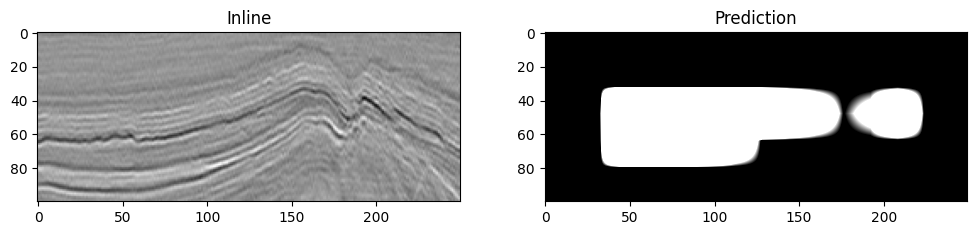

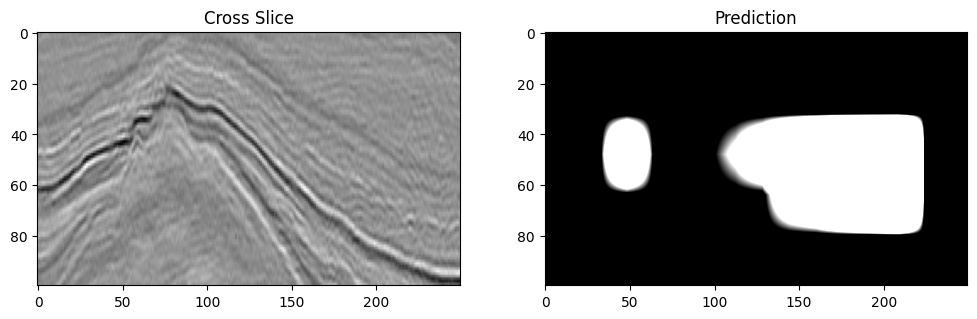

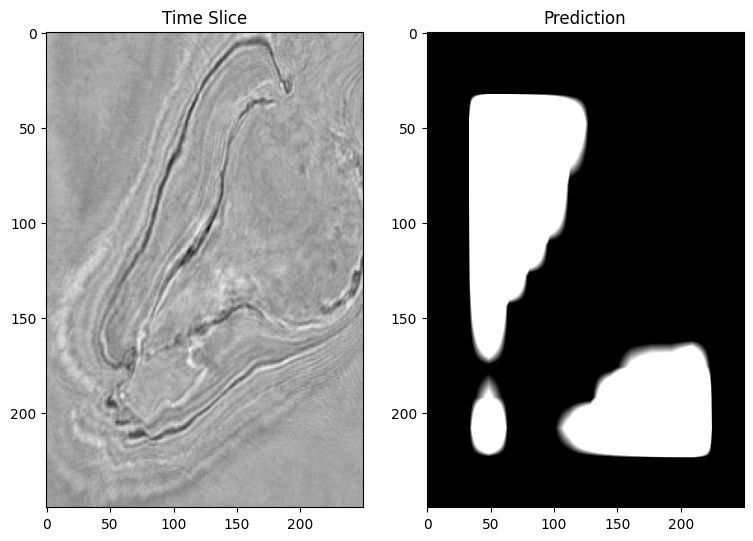

In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from PIL import Image

k1,k2,k3 = 40,200,50
gx1 = data[k1,:,:]
gy1 = class_cube[0][k1,:,:]
gx2 = data[:,k2,:]
gy2 = class_cube[0][:,k2,:]
gx3 = data[:,:,k3]
gy3 = class_cube[0][:,:,k3]

#Inline slice
fig = plt.figure(figsize=(12,12))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx3,cmap=plt.cm.gray)
plt.title("Inline")
p2 = plt.subplot(1,2,2)
p2.imshow(gy3,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)
plt.title("Prediction")

#Crossline slice
fig = plt.figure(figsize=(12,12))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx2,aspect=1.5,cmap=plt.cm.gray)
plt.title("Cross Slice")
p2 = plt.subplot(1,2,2)
p2.imshow(gy2,aspect=1.5,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)
plt.title("Prediction")

#Time slice
fig = plt.figure(figsize=(9,9))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx1,aspect=1.5,cmap=plt.cm.gray)
plt.title("Time Slice")
p2 = plt.subplot(1,2,2)
p2.imshow(gy1,aspect=1.5,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)
plt.title("Prediction")
plt.show()